In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#| default_exp trait

## Trait
> contains logic for quantitative traits

In [ ]:
#| export

from chewc.core import *
import torch
import attr
from typing import Tuple, Optional, List
from fastcore.test import *
import matplotlib.pyplot as plt

def select_qtl_loci(num_qtl_per_chromosome: int, genome:Genome) -> torch.Tensor:
    """
    Randomly selects loci to be QTLs on each chromosome.

    Args:
    ----
    num_qtl_per_chromosome (int): Number of QTLs to select per chromosome.
    genome (Genome): Genome object containing the chromosome structure.

    Returns:
    -------
    torch.Tensor: A boolean tensor indicating which loci are QTLs. 
                  Shape: (number_chromosomes, loci_per_chromosome)
    """
    
    assert num_qtl_per_chromosome <= genome.loci_per_chromosome, "too many qtls for this trait given your Genome object"
    assert num_qtl_per_chromosome > 0, "you need at least 1 QTL per chromosome"
    

    qtl_indices = []
    for i in range(genome.number_chromosomes):
        # Randomly sample indices for QTLs on the current chromosome
        chromosome_indices = torch.randperm(genome.loci_per_chromosome)[:num_qtl_per_chromosome]
        
        # Create a boolean tensor for the current chromosome, marking QTL positions as True
        chromosome_qtl_flags = torch.zeros(genome.loci_per_chromosome, dtype=torch.bool)
        chromosome_qtl_flags[chromosome_indices] = True
        
        qtl_indices.append(chromosome_qtl_flags)
    
    return torch.stack(qtl_indices)

In [ ]:
#| export 


def calculate_genetic_variance(founder_pop: torch.Tensor, marker_effects: torch.Tensor, genome: Genome) -> float:
    """
    Calculates the additive genetic variance in the founder population.

    Args:
        founder_pop (torch.Tensor): Tensor of founder haplotypes. 
                                    Shape: (n_founders, ploidy, number_chromosomes, loci_per_chromosome)
        marker_effects (torch.Tensor): Tensor of marker effects. 
                                       Shape: (number_chromosomes, loci_per_chromosome)
        genome (Genome): The genome object.

    Returns:
        torch.Tensor: The additive genetic variance.
    """
    # Convert to float for mean operation to work
    founder_pop = founder_pop.float()
    # Calculate allele frequencies in the founder population
    allele_frequencies = founder_pop.mean(dim=(0, 1))  # Average across founders and ploidy

    # Calculate the genetic value contributions of each locus
    locus_contributions = 2 * allele_frequencies * (1 - allele_frequencies) * marker_effects**2

    # Sum the contributions across all loci to get the total genetic variance
    genetic_variance = locus_contributions.sum().item()

    return genetic_variance

In [ ]:
#| export
from typing import Optional

@attr.s(auto_attribs=True)
class TraitA:
    """
    Represents a trait with only additive genetic effects.

    Attributes:
    ----------
    qtl_map (torch.Tensor): A boolean tensor indicating which loci are QTLs. 
                           Shape: (number_chromosomes, loci_per_chromosome)
    genome (Genome): The genome object.
    founder_pop (torch.Tensor): Tensor of founder haplotypes. 
                                Shape: (n_founders, ploidy, number_chromosomes, loci_per_chromosome)
    target_mean (float): The desired genetic mean for the trait.
    target_variance (float): The desired genetic variance for the trait.
    additive_effects (torch.Tensor, optional): A tensor of additive effects for each QTL 
                                           (if pre-generated). Defaults to None.
    intercept (float): The intercept value, calculated during initialization.
    
    Methods:
    -------

    """

    qtl_map: torch.Tensor 
    sim_param: SimParam
    target_mean: float
    target_variance: float
    distribution: str ='normal'
    intercept: None = 0
        
    def calculate_scaled_additive_dosages(self, genotypes: torch.Tensor) -> torch.Tensor:
        """
        Calculates the scaled additive genotype dosages.

        Args:
            genotypes (torch.Tensor): A tensor representing the genotypes of individuals.
                                     Shape: (n_individuals, ploidy, number_chromosomes, loci_per_chromosome).

        Returns:
            torch.Tensor: A tensor of scaled additive dosages. 
                         Shape: (n_individuals, ploidy, number_chromosomes, loci_per_chromosome).
        """
        return (genotypes - self.sim_param.genome.ploidy / 2) * (2 / self.sim_param.genome.ploidy)

    def sample_initial_effects(self):
        """
        Sample initial values for the genetic effects based on the specified distribution.
        """
        if self.distribution == 'normal':
            # Sample from a standard normal distribution
            effects = torch.randn(self.sim_param.genome.genetic_map.shape)
        elif self.distribution == 'gamma':
            # Sample from a gamma distribution with specified shape and scale=1
            effects = torch.distributions.Gamma(self.shape, 1).sample((self.sim_param.genome.genetic_map.shape,))
            # Randomly assign a positive or negative sign
            signs = torch.tensor(np.random.choice([-1, 1], self.sim_param.genome.genetic_map.shape))
            effects *= signs
        else:
            raise ValueError("Unsupported distribution type. Choose 'normal' or 'gamma'.")
        self.initial_effects = effects
        
    def scale_genetic_effects(self):
        """
        Scale the marker effects to achieve a specified genetic variance in the founder population.

        Parameters:
        founder_pop (torch.Tensor): Tensor representing the founder population. Shape: [num_individuals, num_chromosomes, dim1, dim2]
        marker_effects (torch.Tensor): Tensor of marker effects. Shape: [dim1, dim2]
        target_variance (float): The target genetic variance to achieve.

        Returns:
        torch.Tensor: Scaled marker effects.
        """
        # Step 1: Calculate the genetic value for each individual using the initally sampled marker effects
        genetic_values = (self.sim_param.founder_pop * self.initial_effects.unsqueeze(0).unsqueeze(0)).sum(dim=[1,2, 3])
        # Step 2: Calculate the initial genetic variance
        initial_variance = genetic_values.var(dim=0)
        # Step 3: Calculate scaling constant and scale the effects
        scaling_factor = torch.sqrt(self.target_variance / initial_variance)
        scaled_effects = self.initial_effects * scaling_factor
        self.scaled_effects = scaled_effects

    def calculate_genetic_values(self, pop):
        """
        Calculates the genetic value for each individual in a pop [ind,ploidy,chr,loci]
        """
        # pop.shape = [50,2,10,10]
        # self.scaled_effects.shape = [10,10]
        # output [50]
        if self.intercept:
            return torch.einsum('ijkl,kl->i', self.calculate_scaled_additive_dosages(pop.float()), self.scaled_effects) + self.intercept
        else:
            return torch.einsum('ijkl,kl->i', self.calculate_scaled_additive_dosages(pop.float()), self.scaled_effects)

    def calculate_intercept(self):
        """
        Calculate the intercept to achieve the desired mean genetic value of the population.
        """
        current_mean = self.calculate_genetic_values(self.sim_param.founder_pop).mean()
        self.intercept = self.target_mean - current_mean
        

    def phenotype(self, pop, h2=None, varE=None, reps=1):
        """
        Generate phenotypes for the individuals in the population.

        Args:
        pop (Pop): The population object.
        h2 (float, optional): Target narrow-sense heritability. Defaults to None.
        varE (float, optional): Target environmental variance. Defaults to None.
        reps (int, optional): Number of repetitions for averaging. Defaults to 1.

        Returns:
        torch.Tensor: A tensor of average phenotype values for each individual.
                      Shape: (n_individuals,)

        Raises:
        ValueError: If both h2 and varE are provided or neither are provided.
        """

        if h2 is not None and varE is not None:
            raise ValueError("Provide either h2 or varE, not both.")
        if h2 is None and varE is None:
            raise ValueError("Provide either h2 or varE.")

        genetic_values = self.calculate_genetic_values(pop)

        if h2 is not None:
            # Calculate varE based on target heritability
            varG = genetic_values.var()
            varE = (varG / h2) - varG  

        # Generate phenotypes for each repetition
        phenotypes = torch.zeros(len(pop))
        for _ in range(reps):
            error = torch.randn(len(pop)) * torch.sqrt(varE)
            phenotypes += genetic_values + error

        # Average phenotypes across repetitions
        phenotypes /= reps

        return phenotypes
    

In [ ]:
#| export
def create_multiple_traits(sim_param: SimParam, 
                           n_traits: int,
                           target_means: torch.Tensor,
                           target_variances: torch.Tensor,
                           correlations: torch.Tensor,
                           num_qtl_per_chromosome: int,
                           distribution: str = 'normal') -> List[TraitA]:
    """
    Creates multiple additive traits that share the same QTL map.

    Args:
        sim_param (SimParam): The SimParam object.
        n_traits (int): The number of traits to create.
        target_means (torch.Tensor): A tensor of desired means for each trait. 
                                      Shape: (n_traits,).
        target_variances (torch.Tensor): A tensor of desired variances for each trait. 
                                         Shape: (n_traits,).
        correlations (torch.Tensor): A 2D correlation matrix for the marker effects between traits. 
                                     Shape: (n_traits, n_traits).
        num_qtl_per_chromosome (int): Number of QTLs to select per chromosome (shared by all traits).
        distribution (str, optional): Distribution to sample initial effects from. 'normal' or 'gamma'. Defaults to 'normal'.

    Returns:
        List[TraitA]: A list of TraitA objects, each representing one of the created traits.
    """
    # Check input dimensions
    n_traits = target_variances.shape[0]
    test_eq(target_means.shape, (n_traits,))
    test_eq(target_variances.shape, (n_traits,))
    test_eq(correlations.shape, (n_traits, n_traits))
    
    # Sample shared QTL positions
    qtl_map = select_qtl_loci(num_qtl_per_chromosome, sim_param.genome)
    
    # Generate correlated effects 
    if distribution == 'normal':
        # Cholesky decomposition for correlated normal variables
        L = torch.linalg.cholesky(correlations)
        uncorrelated_effects = torch.randn((sim_param.genome.number_chromosomes, sim_param.genome.loci_per_chromosome, n_traits))
        correlated_effects = torch.matmul(uncorrelated_effects, L.T)
        
    elif distribution == 'gamma':
        # Not as straightforward to generate correlated gamma variables directly 
        # One option is to use copulas (requires additional libraries and complexity)
        raise NotImplementedError("Correlated gamma distribution for multiple traits is not yet implemented.")

    else:
        raise ValueError("Unsupported distribution type. Choose 'normal' or 'gamma'.")

    # Create TraitA objects
    traits = []
    for i in range(n_traits):
        # Extract effects for the current trait
        trait_effects = correlated_effects[:, :, i]  
        
        # Multiply trait effects by the QTL map
        trait_effects = trait_effects * qtl_map

        trait = TraitA(
            qtl_map=qtl_map,
            sim_param=sim_param,
            target_mean=target_means[i],
            target_variance=target_variances[i],
            distribution=distribution
        )
        trait.initial_effects = trait_effects
        trait.scale_genetic_effects()
        trait.calculate_intercept()
        traits.append(trait)

    return traits


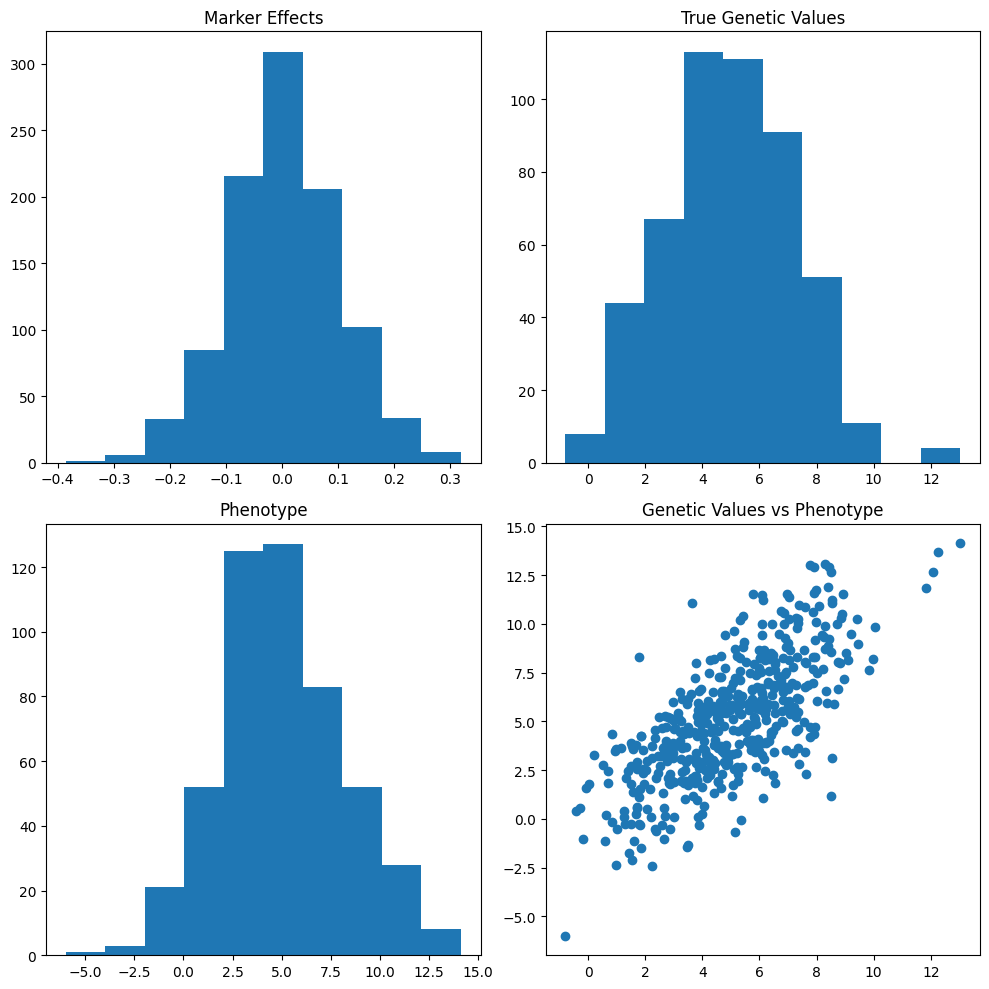

In [ ]:
ploidy = 2
number_chromosomes = 10
loci_per_chromosome = 100
genetic_map = create_random_genetic_map(number_chromosomes,loci_per_chromosome)
crop_genome = Genome(ploidy, number_chromosomes, loci_per_chromosome, genetic_map)

n_founders = 500
founder_pop = create_random_founder_pop(crop_genome , n_founders)
simparam = SimParam
simparam.founder_pop = founder_pop
simparam.genome = crop_genome


#add a single additive trait
qtl_loci = 100
qtl_map = select_qtl_loci(qtl_loci,simparam.genome)

ta = TraitA(qtl_map,simparam,5, 5)
ta.sample_initial_effects()
ta.scale_genetic_effects()
ta.calculate_intercept()

# Create a 2x2 grid of plots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))  # Adjust figsize as needed

# Plot 1: Scaled Effects Histogram
axs[0, 0].hist(ta.scaled_effects.flatten())
axs[0, 0].set_title('Marker Effects')

# Plot 2: True Genetic Values Histogram
genetic_values = ta.calculate_genetic_values(simparam.founder_pop)
axs[0, 1].hist(genetic_values)
axs[0, 1].set_title('True Genetic Values')

# Plot 3: Phenotype Histogram
phenotypes = ta.phenotype(simparam.founder_pop, h2=0.5)  # Assuming 'h2' is a parameter for heritability in the phenotype method
axs[1, 0].hist(phenotypes)
axs[1, 0].set_title('Phenotype')

# Plot 4: Scatter Plot of Genetic Values vs Phenotypes
axs[1, 1].scatter(genetic_values, phenotypes)
axs[1, 1].set_title('Genetic Values vs Phenotype')

# Display the plots
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [ ]:
# Trait parameters
n_traits = 2
target_means = torch.tensor([10.0, 20.0])
target_variances = torch.tensor([10.0, 1.0])
correlation_matrix = torch.tensor([[1.0, -0.7], 
                                   [ -0.7, 1.0]]) 

num_qtls_per_chromosome = 100

# Create multiple traits
traits = create_multiple_traits(simparam, n_traits, target_means, target_variances, 
                               correlation_matrix, num_qtls_per_chromosome)


<matplotlib.collections.PathCollection>

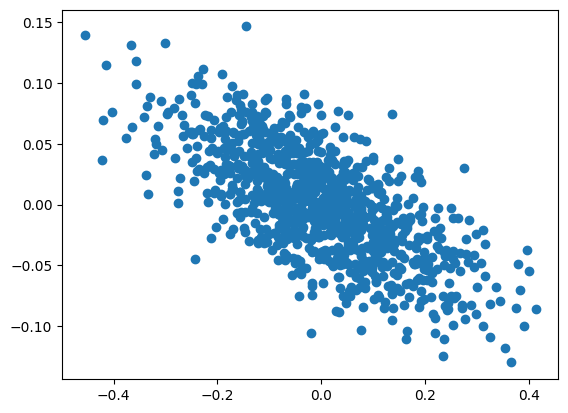

In [ ]:
plt.scatter(traits[0].scaled_effects,traits[1].scaled_effects)

<matplotlib.collections.PathCollection>

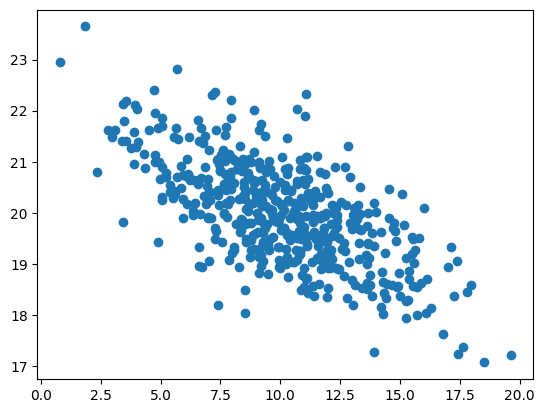

In [ ]:
plt.scatter(traits[0].calculate_genetic_values(founder_pop),traits[1].calculate_genetic_values(founder_pop))

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()